<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/Projet_dlim_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import shutil
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor
from sklearn.cluster import KMeans

In [2]:
shutil.rmtree('/content/metadata', ignore_errors=True)
shutil.rmtree('/content/train', ignore_errors=True)
shutil.rmtree('/content/validation', ignore_errors=True)

In [3]:
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/wider_face_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/metadata/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/train/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_val.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/validation/')

In [4]:
features = [8, 16, 32]
image_size = 256
ignore_threshold = 0.5
batch_size = 32
epochs = 10
k = 9
test_nb_images = 20

In [5]:
def get_right_images(filepath_train, filepath_val, top_path_train, top_path_val):
  map_filename_bbx = {}
  for filepath, top_path in zip([filepath_train, filepath_val], [top_path_train, top_path_val]):
    with open(filepath) as file:
      lines = file.read().splitlines()
      file_name_line_number = 0
      face_line_number = 0
      while file_name_line_number < len(lines):
        number_of_faces = int(lines[file_name_line_number + 1])
        if number_of_faces is 0:
          number_of_faces += 1
        values = []
        key = lines[file_name_line_number]
        while face_line_number < number_of_faces:
          fields = lines[file_name_line_number + 2 + face_line_number].split()
          fields = list(map(int, fields))
          if fields[4] is not 0 or fields[5] is not 0 or fields[6] is not 0 or fields[7] is not 0 or fields[8] is not 0 or fields[9] is not 0:
            face_line_number += 1
            values = []
            break
          value = np.array([x for x in fields[:4]])
          if len(value) > 0:
            values.append(value)
          face_line_number += 1
        if values:
          map_filename_bbx[top_path + key] = values
        file_name_line_number += number_of_faces + 2
        face_line_number = 0
  return map_filename_bbx

In [6]:
def get_aspect_ratio(right_images):
  aspect_ratio_list = []
  for key in list(right_images):
    image_size = Image.open(key).size
    if image_size[0] < image_size[1]:
      del right_images[key]
      continue
    aspect_ratio_list.append(float(image_size[0]) / float(image_size[1]))
  return right_images

In [7]:
def normalize_images(images):
  means = images.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
  stds = images.std(axis=(0,1,2), keepdims=True).astype(np.float32)
  images = (images - means) / stds
  return images.astype(np.float32)

In [8]:
def get_iou(bbx1, bbx2):
  x_left = np.maximum(bbx1[..., 0], bbx2[..., 0])
  y_top = np.maximum(bbx1[..., 1], bbx2[..., 1])
  x_right = np.minimum(bbx1[..., 0] + bbx1[..., 2], bbx2[..., 0] + bbx2[..., 2])
  y_bottom = np.minimum(bbx1[..., 1] + bbx1[..., 3], bbx2[..., 1] + bbx2[..., 3])

  intersection_area = (np.maximum(np.zeros(x_right.shape), x_right - x_left) * np.maximum(np.zeros(y_bottom.shape), y_bottom - y_top)).astype(np.float32)

  bbx1_area = bbx1[..., 2] * bbx1[..., 3]
  bbx2_area = bbx2[..., 2] * bbx2[..., 3]

  iou = intersection_area / (bbx1_area + bbx2_area - intersection_area)
  iou = np.nan_to_num(iou)
  return iou

In [9]:
def get_iou_not_same_shape(boxes, predictions):

    boxes = tf.expand_dims(boxes, 0)
    predictions = tf.expand_dims(predictions, 1)
    new_shape = tf.broadcast_dynamic_shape(tf.shape(predictions), tf.shape(boxes))
    boxes = tf.broadcast_to(boxes, new_shape)
    predictions = tf.broadcast_to(predictions, new_shape)

    x_box = boxes[..., 0]
    y_box = boxes[..., 1]
    w_box = boxes[..., 2]
    h_box = boxes[..., 3]

    x_pred = predictions[..., 0]
    y_pred = predictions[..., 1]
    w_pred = predictions[..., 2]
    h_pred = predictions[..., 3]

    x_left = tf.math.maximum(x_box, x_pred)
    y_top = tf.math.maximum(y_box, y_pred)
    x_right = tf.math.minimum(x_box + w_box, x_pred + w_pred)
    y_bottom = tf.math.minimum(y_box + h_box, y_pred + h_pred)

    intersection_area = tf.math.maximum(0, x_right - x_left) * tf.math.maximum(0, y_bottom - y_top)

    boxes_area = w_box * h_box
    predictions_area = w_pred * h_pred

    union = boxes_area + predictions_area - intersection_area

    iou = intersection_area / union
    iou = tf.where(tf.math.is_nan(iou), tf.ones_like(iou) * 0, iou)

    return iou

In [10]:
def get_images_and_bbxs(right_images, image_size):
    image_list = []
    bbx_list = []
    for item in right_images.items():
      image = Image.open(item[0])

      image = np.array(image)
      ratio = min(image_size / image.shape[1], image_size / image.shape[0])
      new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
      image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

      padding_amount_rows = (image_size - image.shape[0]) / 2
      padding_amount_cols = (image_size - image.shape[1]) / 2

      values = []
      for bbx in item[1]:
        if (bbx==0).all():
          continue
        new_bbx = bbx * ratio
        new_bbx[0] += padding_amount_cols
        new_bbx[1] += padding_amount_rows
        values.append(new_bbx)
      
      if not values:
        continue
      
      bbxs = (np.stack(values) / image_size).astype(np.float32)

      image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
      image_list.append(image)
      bbx_list.append(bbxs)
        
    images = np.stack(image_list)
    return images, bbx_list

In [11]:
def get_best_anchor_indices(boxes, anchors):
  boxes = np.tile(boxes[:, np.newaxis, :], [1, anchors.shape[0], 1])
  anchors = np.tile(anchors[np.newaxis, :, :], [boxes.shape[0], 1, 1])
  intersections = np.minimum(boxes[..., 0], anchors[..., 0]) * np.minimum(boxes[..., 1], anchors[..., 1])
  boxes_area = boxes[..., 0] * boxes[..., 1]
  anchors_area = anchors[..., 0] * anchors[..., 1]
  ious = intersections / (boxes_area + anchors_area - intersections)
  ious = np.nan_to_num(ious)
  return np.argmax(ious, axis=1)

In [44]:
a = np.random.rand(9, 4)
b = np.random.rand(5, 4)
out = get_iou_not_same_shape(b, a)
print(out.shape)
#print(out[np.isin(out, [5, 6, 7])] % 3)

(9, 5)


In [13]:
def set_labels(bbx_list, anchors, features, valid_indices):
  cell_size = 1.0 / features
  Y = np.zeros((len(bbx_list), features, features, len(valid_indices), 5), dtype=np.float32)
  for image_index, bbxs in enumerate(bbx_list):
    object_midpoint = np.concatenate([(bbxs[:, 0] + (bbxs[:, 2] / 2)).reshape((-1, 1)), (bbxs[:, 1] + (bbxs[:, 3] / 2)).reshape((-1, 1))], axis=1)
    indices_anchors = get_best_anchor_indices(bbxs[:, 2:], anchors)
    mask = np.isin(indices_anchors, valid_indices)
    object_midpoint = object_midpoint[mask, :]
    indices_anchors = indices_anchors[mask] % 3
    cell_index = np.floor(object_midpoint * features).astype(np.int32)
    wh = bbxs[:, 2:][mask, :]
    assert(wh.shape[0] == cell_index.shape[0] == indices_anchors.shape[0] == object_midpoint.shape[0])
    if len(indices_anchors) == 0:
      continue
    Y[image_index, cell_index[:, 1], cell_index[:, 0], indices_anchors, :] = np.stack([np.ones_like(object_midpoint[:, 0]), object_midpoint[:, 0], object_midpoint[:, 1], wh[:, 0], wh[:, 1]], axis=-1)
  return Y

In [14]:
#test = np.zeros((32, 16, 16, 3, 5))
#out = np.stack([np.array([1, 1, 1]), np.array([1, 2, 3]), np.array([4, 5, 6]), np.array([4, 5, 6]), np.array([7, 8, 9])], axis=-1)
#print(out.shape)
#test[10, np.array([0, 1, 2]), np.array([5, 6, 7]), np.array([0, 2, 1]), :] = out

In [15]:
from sklearn.model_selection import train_test_split

right_images = get_right_images('/content/metadata/wider_face_split/wider_face_train_bbx_gt.txt', '/content/metadata/wider_face_split/wider_face_val_bbx_gt.txt', '/content/data/train/WIDER_train/images/', '/content/data/validation/WIDER_val/images/')
print(len(right_images))

4771


In [16]:
def get_bbxs_clusters(bbx_list, k, image_size):
  widths_and_heights = []
  for bbx in bbx_list:
    widths_and_heights.append(bbx[:, 2:])
  X = np.concatenate(widths_and_heights, axis=0)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
  anchors = kmeans.cluster_centers_.astype(np.float32).reshape((-1, 2))
  areas = np.prod(anchors, axis=1)
  indices = np.argsort(areas)
  sorted_anchors = anchors[indices]
  return sorted_anchors

In [17]:
images, bbx_list = get_images_and_bbxs(right_images, image_size)
anchors = get_bbxs_clusters(bbx_list, k, image_size)
print(anchors)
print(images.shape)

[[0.03278016 0.04092728]
 [0.06651902 0.08967111]
 [0.09805764 0.13433121]
 [0.13662681 0.18527794]
 [0.17984447 0.24516846]
 [0.23487213 0.3169095 ]
 [0.29764575 0.40217566]
 [0.372976   0.50065506]
 [0.5116139  0.65165365]]
(4763, 256, 256, 3)


In [18]:
Y_large = set_labels(bbx_list, anchors, features[0], [6, 7, 8])
print(Y_large.shape)
Y_medium = set_labels(bbx_list, anchors, features[1], [3, 4, 5])
print(Y_medium.shape)
Y_small = set_labels(bbx_list, anchors, features[2], [0, 1, 2])
print(Y_small.shape)
Y = [Y_large, Y_medium, Y_small]
print(len(bbx_list))

(4763, 8, 8, 3, 5)
(4763, 16, 16, 3, 5)
(4763, 32, 32, 3, 5)
4763


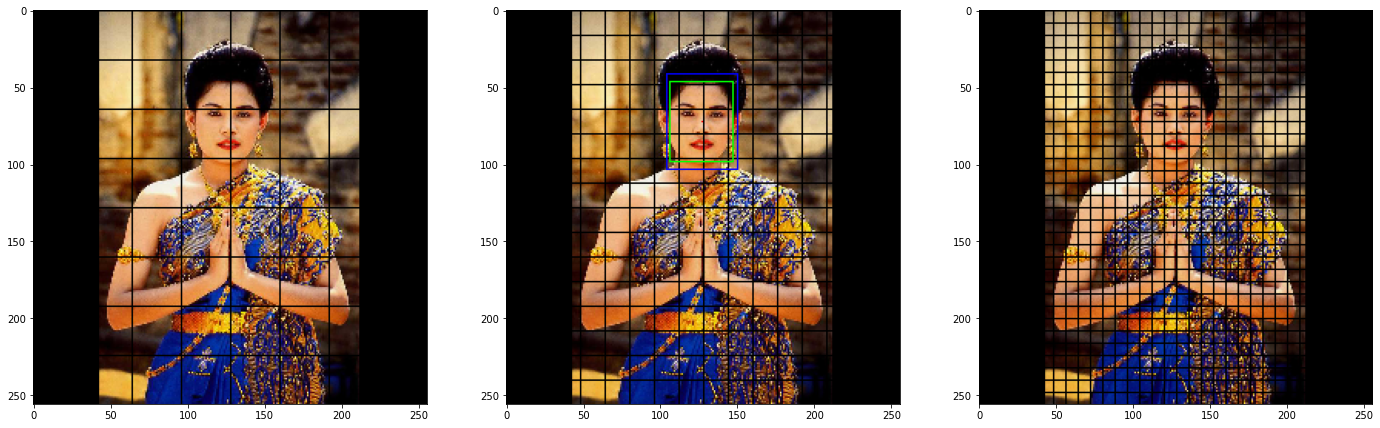

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(24, 10))
index = np.random.randint(0, Y[0].shape[0])
test_image = images[index].copy()

for index_feature, (feature, y) in enumerate(zip(features, Y)):
  Y_test = y[index]
  current_image = test_image.copy()
  cell_size = image_size / feature
  current_image[::int(cell_size), :, :] = 0
  current_image[:, ::int(cell_size), :] = 0
  for i in range(Y_test.shape[0]):
    for j in range(Y_test.shape[1]):
      for t in range(Y_test.shape[2]):
        if Y_test[i, j, t, :].any():
          bbox = Y_test[i, j, t, 1:]
          anchor_index = 3 * (2 - index_feature) + t
          w_h_box = (anchors[anchor_index] * image_size).astype(np.int32)
          w_h_true = (bbox[2:] * image_size).astype(np.int32)
          object_midpoint_x_y = bbox[0:2] * image_size
          current_image[int(object_midpoint_x_y[1]), int(object_midpoint_x_y[0]), :] = np.array([255, 0, 0])
          x_y_true = np.maximum(0, object_midpoint_x_y - (w_h_true / 2)).astype(np.int32)
          x_y_box = np.maximum(0, object_midpoint_x_y - (w_h_box / 2)).astype(np.int32)
          current_image = cv.rectangle(current_image, (x_y_true[0], x_y_true[1]), (x_y_true[0] + w_h_true[0], x_y_true[1] + w_h_true[1]), (0, 255, 0), 1)
          current_image = cv.rectangle(current_image, (x_y_box[0], x_y_box[1]), (x_y_box[0] + w_h_box[0], x_y_box[1] + w_h_box[1]), (0, 0, 255), 1)
  ax[index_feature].imshow(current_image)

In [20]:
images = normalize_images(images)

del right_images
all_indices = list(range(images.shape[0]))
test_size_percent = test_nb_images / images.shape[0]
train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
del all_indices
X_train_first = images[train_indices, ...]
X_test = images[test_indices, ...]
del images
Y_test = [bbx_list[i] for i in test_indices]
Y_train_first = []
for y in Y:
  Y_train_first.append(y[train_indices, ...])
del Y

all_indices = list(range(X_train_first.shape[0]))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42)
del all_indices
X_train = X_train_first[train_indices, ...]
X_val = X_train_first[test_indices, ...]
del X_train_first
Y_train = []
Y_val = []
for y in Y_train_first:
  Y_train.append(y[train_indices, ...])
  Y_val.append(y[test_indices, ...])
del Y_train_first, test_indices
boxes_train = [bbx_list[i] for i in train_indices]
del train_indices

print(X_train.shape)
print(Y_train[0].shape)
print(X_val.shape)
print(Y_val[0].shape)
print(X_test.shape)
print(len(Y_test))
print(len(boxes_train))

(3794, 256, 256, 3)
(3794, 8, 8, 3, 5)
(949, 256, 256, 3)
(949, 8, 8, 3, 5)
(20, 256, 256, 3)
(1, 4)
3794


In [22]:
def get_object_loss(bo, label, noobj_mask, lambda_obj, lambda_noobj):
  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss_conf_obj = tf.reduce_sum(label * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  loss_conf_noobj = tf.reduce_sum(noobj_mask * bce(label[..., np.newaxis], bo[..., np.newaxis]), axis=(1, 2, 3))
  return (lambda_obj * loss_conf_obj) + (lambda_noobj * loss_conf_noobj)

In [23]:
def get_location_loss(label, prediction, t_xy, t_wh, lambda_xy, lambda_wh):
  loss_xy = tf.reduce_sum(label * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
  loss_wh = tf.reduce_sum(label * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))
  return (lambda_xy * loss_xy) + (lambda_wh * loss_wh)

In [24]:
def loss(box_list, features, anchors, ignore_threshold):
  def get_loss_sub(label, prediction):
    grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
    #grid = tf.tile(grid, (1, 1, anchors.shape[0], 1))

    bx_by = tf.math.sigmoid(prediction[..., 1:3]) + grid
    bx_by = bx_by / tf.cast(features, tf.float32)
    bo = tf.math.sigmoid(prediction[..., 0])
    bw_bh = tf.exp(prediction[..., 3:]) * anchors
    bx_by = tf.maximum(0, bx_by - bw_bh / 2)
    abs_predictions = tf.reshape(tf.concat([bx_by, bw_bh], axis=-1), (label.shape[0], -1, 4))

    ious = []
    for index, boxes in enumerate(box_list):
      current_pred = abs_predictions[index]
      #print(np.unique(current_pred))
      iou = get_iou_not_same_shape(boxes, current_pred)
      ious.append(np.amax(iou, axis=1))
    ious = np.stack(ious).reshape((label.shape[0], features, features, len(anchors)))

    noobj_mask = tf.cast(ious < ignore_threshold, tf.float32) * (1 - label[..., 0])

    t_wh = tf.math.log(label[..., 3:] / anchors)
    t_wh = tf.where(tf.logical_or(tf.math.is_inf(t_wh), tf.math.is_nan(t_wh)), tf.zeros_like(t_wh), t_wh)
    t_xy = label[..., 1:3] * features - grid

    #loss_xy = tf.reduce_sum(label[..., 0] * (tf.math.square(tf.math.sigmoid(prediction[..., 1]) - t_xy[..., 0]) + tf.math.square(tf.math.sigmoid(prediction[..., 2]) - t_xy[..., 1])), axis=(1, 2, 3))
    #loss_wh = tf.reduce_sum(label[..., 0] * (tf.math.square(prediction[..., 3] - t_wh[..., 0]) + tf.math.square(prediction[..., 4] - t_wh[..., 1])), axis=(1, 2, 3))

    location_loss = get_location_loss(label[..., 0], prediction, t_xy, t_wh, 5, 5)

    #loss_conf_obj = tf.reduce_sum(label[..., 0] * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    #loss_conf_noobj = tf.reduce_sum(noobj_mask * tf.math.square(bo - label[..., 0]), axis=(1, 2, 3))
    object_loss = get_object_loss(bo, label[..., 0], noobj_mask, 5, 0.5)

    #total_loss = 5 * loss_xy + 5 * loss_wh + 5 * loss_conf_obj + 0.5 * loss_conf_noobj
    total_loss = location_loss + object_loss

    return total_loss

  return get_loss_sub

In [24]:
#loos_obj = loss(bbx_list[:32], features, anchors, ignore_threshold)
#train_data_test = np.random.rand(32, 16, 16, 5, 5).astype(np.float32)
#gt_data_test = np.random.rand(32, 16, 16, 5, 5).astype(np.float32)
#out = loos_obj(gt_data_test, train_data_test)

In [25]:
#def resnet_block(inputs, filters, reduce):
#  shortcut = 0
#  if reduce:
#    x = layers.Conv2D(filters, 3, strides=2, padding="same")(inputs)
#    shortcut = layers.Conv2D(filters, 3, strides=2, padding="same")(inputs)
#    shortcut = layers.BatchNormalization()(shortcut)
#  else:
#    x = layers.Conv2D(filters, 3, strides=1, padding="same")(inputs)
#    shortcut = inputs
#
#  x = layers.BatchNormalization()(x)
#  x = layers.LeakyReLU(alpha=0.1)(x)
#
#  x = layers.Conv2D(filters, 3, strides=1, padding="same")(x)
#  x = layers.BatchNormalization()(x)
#
#  x = layers.add([x, shortcut])
#
#  x = layers.LeakyReLU(alpha=0.1)(x)
#
#  return x

In [25]:
def darknetBlock(inputs, filters1, filters2):
  x = layers.Conv2D(filters1, 1, strides=1, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)

  x = layers.Conv2D(filters2, 3, strides=1, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  
  x = layers.add([inputs, x])
  return x

In [26]:
def convBlock(inputs, filters, kernel_size, strides):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(alpha=0.1)(x)
  return x

In [31]:
from tensorflow.keras.layers import concatenate

def get_extractor(image_size):

    inputs = keras.Input((image_size, image_size, 3))

    x = convBlock(inputs, 16, 3, 1)
    x = convBlock(x, 32, 3, 2)

    x = darknetBlock(x, 16, 32)
    x = convBlock(x, 64, 3, 2)

    for i in range(2):
      x = darknetBlock(x, 32, 64)

    x = convBlock(x, 128, 3, 2)

    for i in range(2):
      x = darknetBlock(x, 64, 128)

    small = x

    x = convBlock(x, 256, 3, 2)

    for i in range(2):
      x = darknetBlock(x, 128, 256)

    medium = x

    x = convBlock(x, 512, 3, 2)

    for i in range(2):
      x = darknetBlock(x, 256, 512)

    large = x

    model = keras.Model(inputs, (small, medium, large))
    return model

keras.backend.clear_session()
extractor = get_extractor(image_size)
extractor.summary()
keras.backend.clear_session()
del extractor

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
def get_detector(image_size):

  inputs = keras.Input((image_size, image_size, 3))

  extractor = get_extractor(image_size)
  small,medium, large = extractor(inputs)

  x = convBlock(large, 256, 1, 1)
  x = convBlock(x, 512, 3, 1)
  x = convBlock(x, 256, 1, 1)
  y_large = convBlock(x, 512, 3, 1)
  y_large = layers.Conv2D(3 * 5, 1, padding='same')(y_large)

  x = layers.UpSampling2D(size=(2, 2))(x)
  x = layers.Concatenate()([x, medium])
  x = convBlock(x, 128, 1, 1)
  x = convBlock(x, 256, 3, 1)
  x = convBlock(x, 128, 1, 1)
  y_medium = convBlock(x, 256, 3, 1)
  y_medium = layers.Conv2D(3 * 5, 1, padding='same')(y_medium)

  x = layers.UpSampling2D(size=(2, 2))(x)
  x = layers.Concatenate()([x, small])
  x = convBlock(x, 64, 1, 1)
  x = convBlock(x, 128, 3, 1)
  x = convBlock(x, 64, 1, 1)
  y_small = convBlock(x, 128, 3, 1)
  y_small = layers.Conv2D(3 * 5, 1, padding='same')(y_small)

  y_small = layers.Reshape((y_small.shape[1], y_small.shape[2], 3, 5))(y_small)
  y_medium = layers.Reshape((y_medium.shape[1], y_medium.shape[2], 3, 5))(y_medium)
  y_large = layers.Reshape((y_large.shape[1], y_large.shape[2], 3, 5))(y_large)

  model = keras.Model(inputs, (y_small, y_medium, y_large))
  return model

keras.backend.clear_session()
detector = get_detector(image_size)
detector.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       ((None, 32, 32, 128) 5078160     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 8, 8, 256)    131328      functional_1[0][2]               
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 8, 8, 256)    1024        conv2d_24[0][0]                  
_______________________________________________________________________________________

In [25]:
def convert_grid_to_image_reference(preds, features, anchors):
  grid = tf.meshgrid(tf.range(features, dtype=tf.float32), tf.range(features, dtype=tf.float32))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  bx_by = (tf.math.sigmoid(preds[..., 1:3]) + grid) / features
  bo = tf.math.sigmoid(preds[..., 0])
  bw_bh = tf.exp(preds[..., 3:]) * anchors
  bx_by = tf.maximum(0, bx_by - bw_bh / 2)
  out = tf.concat([tf.expand_dims(bo, axis=-1), bx_by, bw_bh], axis=-1)

  return out

In [34]:
def get_accuracy_step1(accuracy_object, preds, y_true, nb_features, anchors):
  preds = convert_grid_to_image_reference(preds, nb_features, anchors)
  ious = get_iou(tf.reshape(y_true[..., 1:], (y_true.shape[0], -1, 4)), tf.reshape(preds[..., 1:], (preds.shape[0], -1, 4)))
  accuracy_object.update_state(tf.reshape(y_true[..., 0], ious.shape), ious)
  return preds

def get_accuracy_step2(accuracy_object):
  train_acc = accuracy_object.result()
  accuracy_object.reset_states()
  return train_acc

In [35]:
val_acc_metric_small = keras.metrics.AUC(curve='PR')
val_acc_metric_medium = keras.metrics.AUC(curve='PR')
val_acc_metric_large = keras.metrics.AUC(curve='PR')
train_acc_metric_small = keras.metrics.AUC(curve='PR')
train_acc_metric_medium = keras.metrics.AUC(curve='PR')
train_acc_metric_large = keras.metrics.AUC(curve='PR')

train_ds=tf.data.Dataset.from_tensor_slices(tf.range(0, X_train.shape[0])).shuffle(buffer_size=X_train.shape[0]).batch(batch_size)
val_ds=tf.data.Dataset.from_tensor_slices((X_val,  Y_val[0], Y_val[1], Y_val[2])).batch(batch_size)
optimizer = keras.optimizers.Adam()

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    running_loss = 0
    # Iterate over the batches of the dataset.
    for step, indices in enumerate(train_ds):

        bbxs = [bbx_list[i] for i in indices]
        x_batch_train = X_train[indices, ...]
        y_large = Y_train[0][indices, ...]
        y_medium = Y_train[1][indices, ...]
        y_small = Y_train[2][indices, ...]

        loss_function_small = loss(bbxs, features[2], anchors[:3, :], ignore_threshold)
        loss_function_medium = loss(bbxs, features[1], anchors[3:6, :], ignore_threshold)
        loss_function_large = loss(bbxs, features[0], anchors[6:, :], ignore_threshold)
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            small, medium, large = detector(x_batch_train, training=True)

            # Compute the loss value for this minibatch.
            loss_value_small = loss_function_small(y_small, small)
            loss_value_medium = loss_function_medium(y_medium, medium)
            loss_value_large = loss_function_large(y_large, large)

            loss_value = loss_value_small + loss_value_medium + loss_value_large

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, detector.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, detector.trainable_weights))
        running_loss += tf.reduce_sum(loss_value) / indices.shape[0]

        _ = get_accuracy_step1(train_acc_metric_small, small, y_small, features[2], anchors[:3, :])
        _ = get_accuracy_step1(train_acc_metric_medium, medium, y_medium, features[1], anchors[3:6, :])
        _ = get_accuracy_step1(train_acc_metric_large, large, y_large, features[0], anchors[6:, :])


    print(f'Epoch: {epoch}, Loss: {running_loss},', end=' ')

    train_acc_small = get_accuracy_step2(train_acc_metric_small)
    train_acc_medium = get_accuracy_step2(train_acc_metric_medium)
    train_acc_large = get_accuracy_step2(train_acc_metric_large)
    train_acc = (train_acc_small + train_acc_medium + train_acc_large) / 3
    
    ## Display metrics at the end of each epoch.

    print("Train accuracy: %.4f," % (float(train_acc),), end=' ')

     # Run a validation loop at the end of each epoch.
    for x_batch_val, y_val_large, y_val_medium, y_val_small in val_ds:

        small_val, medium_val, large_val = detector(x_batch_val, training=False)

        _ = get_accuracy_step1(val_acc_metric_small, small_val, y_val_small, features[2], anchors[:3, :])
        _ = get_accuracy_step1(val_acc_metric_medium, medium_val, y_val_medium, features[1], anchors[3:6, :])
        _ = get_accuracy_step1(val_acc_metric_large, large_val, y_val_large, features[0], anchors[6:, :])

    val_acc_small = get_accuracy_step2(val_acc_metric_small)
    val_acc_medium = get_accuracy_step2(val_acc_metric_medium)
    val_acc_large = get_accuracy_step2(val_acc_metric_large)
    val_acc = (val_acc_small + val_acc_medium + val_acc_large) / 3

    print("Validation acc: %.4f" % (float(val_acc),))
    


Start of epoch 0
Epoch: 0, Loss: 32131.548828125, Train accuracy: 0.9760, Validation acc: 0.9880

Start of epoch 1
Epoch: 1, Loss: 6951.99169921875, Train accuracy: 0.9837, Validation acc: 0.9563

Start of epoch 2
Epoch: 2, Loss: 4816.77880859375, Train accuracy: 0.9803, Validation acc: 0.9942

Start of epoch 3
Epoch: 3, Loss: 3470.008056640625, Train accuracy: 0.9819, Validation acc: 0.9936

Start of epoch 4
Epoch: 4, Loss: 2798.01220703125, Train accuracy: 0.9837, Validation acc: 0.9863

Start of epoch 5
Epoch: 5, Loss: 2533.564453125, Train accuracy: 0.9828, Validation acc: 0.9954

Start of epoch 6
Epoch: 6, Loss: 2033.0584716796875, Train accuracy: 0.9832, Validation acc: 0.9963

Start of epoch 7
Epoch: 7, Loss: 2058.53955078125, Train accuracy: 0.9848, Validation acc: 0.9966

Start of epoch 8
Epoch: 8, Loss: 1752.85205078125, Train accuracy: 0.9838, Validation acc: 0.9979

Start of epoch 9
Epoch: 9, Loss: 1462.320556640625, Train accuracy: 0.9846, Validation acc: 0.9927


In [37]:
detector.save("/content/drive/MyDrive/model_dlim")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_dlim/assets


In [27]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor

detector = keras.models.load_model('/content/drive/MyDrive/model_dlim', compile=False)

In [73]:
def non_max_supression(predictions_boxes, discard_threshold, keep_threshold):
  kept_boxes_images = []
  for t in range(predictions_boxes.shape[0]):
    kept_boxes = []
    image = predictions_boxes[t]
    image = image[image[:, 0] > discard_threshold]
    while image.shape[0] > 0:
      index = np.argmax(image[..., 0])
      max_box = image[index, :][1:]
      kept_boxes.append(max_box.copy())
      image = np.delete(image, index, axis=0)
      ious = get_iou(np.repeat(max_box.reshape((1, -1)), image.shape[0], axis=0), image[:, 1:])
      image = image[ious < keep_threshold]
    if len(kept_boxes) > 0:
      kept_boxes = np.stack(kept_boxes, axis=0).astype(np.float32)
    else:
      kept_boxes = None
    kept_boxes_images.append(kept_boxes)
  return kept_boxes_images

In [74]:
def compute_precision_and_recall(small, medium, large, features, anchors, list_boxes_true):
  small = convert_grid_to_image_reference(small, features[2], anchors[:3, :]).numpy()
  medium = convert_grid_to_image_reference(medium, features[1], anchors[3:6, :]).numpy()
  large = convert_grid_to_image_reference(large, features[0], anchors[6:, :]).numpy()

  small = small.reshape((small.shape[0], -1, 5))
  medium = medium.reshape((medium.shape[0], -1, 5))
  large = large.reshape((large.shape[0], -1, 5))
  preds = np.concatenate([small, medium, large], axis=1)

  list_boxes = non_max_supression(preds, 0.5, 0.2)

  total_precision = 0.0
  total_recall = 0.0
  for true_boxes, pred_boxes in zip(list_boxes_true, list_boxes):
    if pred_boxes is None:
      fn = true_boxes.shape[0]
      fp = 1e-7
      tp = 0
    else:
      ious = get_iou_not_same_shape(true_boxes, pred_boxes)
      fn = max(0, true_boxes.shape[0] - pred_boxes.shape[0])
      fp = np.sum(np.max(ious, axis=1) < 0.5) + max(0, pred_boxes.shape[0] - true_boxes.shape[0])
      tp = np.sum(np.max(ious, axis=1) > 0.5)
    total_precision += tp / (tp + fp)
    total_recall += tp / (tp + fn)
  total_precision /= len(list_boxes)
  total_recall /= len(list_boxes)
  return total_precision, total_recall

In [75]:
small, medium, large = detector.predict(X_test)

precision, recall = compute_precision_and_recall(small, medium, large, features, anchors, Y_test)

#small = convert_grid_to_image_reference(small, features[2], anchors[:3, :]).numpy()
#medium = convert_grid_to_image_reference(medium, features[1], anchors[3:6, :]).numpy()
#large = convert_grid_to_image_reference(large, features[0], anchors[6:, :]).numpy()

#print(small[..., 1])

#preds = convert_grid_to_image_reference(preds, features, anchors).numpy()
#ious = get_iou(Y_test[..., 1:].reshape((Y_test.shape[0], -1, 4)), tf.reshape(preds[..., 1:], (preds.shape[0], -1, 4)))
#
#test_acc_metric.update_state(Y_test[..., 0].reshape(ious.shape), ious)

#small[..., 1:] = small[..., 1:] * image_size
#medium[..., 1:] = medium[..., 1:] * image_size
#large[..., 1:] = large[..., 1:] * image_size

#small = small.reshape((small.shape[0], -1, 5))
#medium = medium.reshape((medium.shape[0], -1, 5))
#large = large.reshape((large.shape[0], -1, 5))
#preds = np.concatenate([small, medium, large], axis=1)
#
#list_boxes = non_max_supression(preds, 0.5, 0.2)
#
#total_precision = 0.0
#total_recall = 0.0
#for true_boxes, pred_boxes in zip(Y_test, list_boxes):
#  if pred_boxes is None:
#    fn = true_boxes.shape[0]
#    fp = 1e-7
#    tp = 0
#  else:
#    ious = get_iou_not_same_shape(true_boxes, pred_boxes)
#    fn = max(0, true_boxes.shape[0] - pred_boxes.shape[0])
#    fp = np.sum(np.max(ious, axis=1) < 0.5) + max(0, pred_boxes.shape[0] - true_boxes.shape[0])
#    tp = np.sum(np.max(ious, axis=1) > 0.5)
#  total_precision += tp / (tp + fp)
#  total_recall += tp / (tp + fn)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.8
Recall: 0.75


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[44 93 79 77]
[113  32  14  21]
[145  46  15  22]
[158  71  24  38]
[129  22  35  43]
[35 16 34 41]
[171  13  26  41]
[73 59 34 46]
[106  68  34  48]
[131  53  11  18]
[129  38  18  24]
[96 63 55 76]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[46 39 16 26]
[160  44  39  75]
[176  90  15  26]
[143 106  14  22]
[175  69  11  18]
[ 92  73  77 135]
[84 99 65 77]
[139  86  32  46]


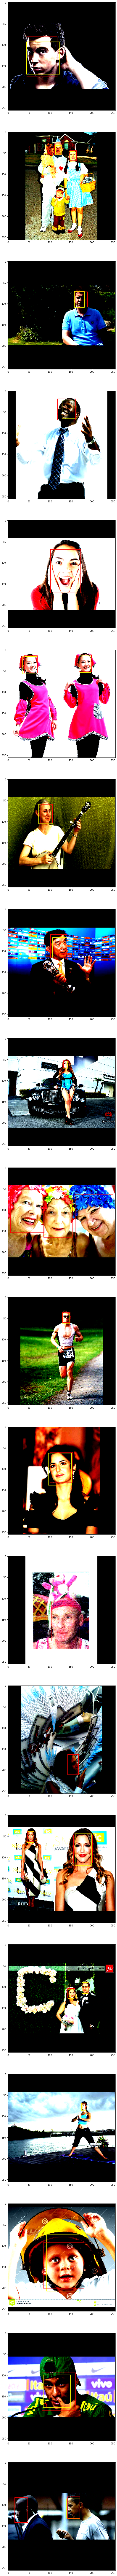

In [51]:
fig, ax = plt.subplots(20, 1, figsize=(24, 200))
for image_index, boxes in enumerate(list_boxes):
  test_image = X_test[image_index].copy()
  true_small = Y_test[2][image_index].copy()
  true_medium = Y_test[1][image_index].copy()
  true_large = Y_test[0][image_index].copy()
  for box_index in range(boxes.shape[0]):
    box = boxes[box_index]
    print(box)
    test_image = cv.rectangle(test_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 255, 0), 1)
  for true_bbxs in [true_small, true_medium, true_large]:
    for i in range(true_bbxs.shape[0]):
      for j in range(true_bbxs.shape[1]):
        for t in range(true_bbxs.shape[2]):
          if true_bbxs[i, j, t, :].any():
            true_box = true_bbxs[i, j, t, 1:]
            true_box = (true_box * image_size).astype(np.int32)
            true_box[:2] = true_box[:2] - (true_box[2:] / 2)
            test_image = cv.rectangle(test_image, (true_box[0], true_box[1]), (true_box[0] + true_box[2], true_box[1] + true_box[3]), (255, 0, 0), 1)
  ax[image_index].imshow(test_image)